In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

## Acquire

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByState.csv')  

In [3]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


## Prepare 

In [4]:
df = df[df.State.str.contains("Texas")]

In [5]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
549727,1820-01-01,4.489,3.369,Texas,United States
549728,1820-02-01,9.081,2.873,Texas,United States
549729,1820-03-01,12.657,2.423,Texas,United States
549730,1820-04-01,19.215,2.501,Texas,United States
549731,1820-05-01,22.577,2.495,Texas,United States


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 549727 to 552051
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2325 non-null   object 
 1   AverageTemperature             2325 non-null   float64
 2   AverageTemperatureUncertainty  2325 non-null   float64
 3   State                          2325 non-null   object 
 4   Country                        2325 non-null   object 
dtypes: float64(2), object(3)
memory usage: 109.0+ KB


In [7]:
df.dt = pd.to_datetime(df.dt)

In [8]:
df = df.set_index('dt').sort_index()

In [9]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1820-01-01,4.489,3.369,Texas,United States
1820-02-01,9.081,2.873,Texas,United States
1820-03-01,12.657,2.423,Texas,United States
1820-04-01,19.215,2.501,Texas,United States
1820-05-01,22.577,2.495,Texas,United States


In [10]:
#Drop country 
df = df.drop(["Country"],axis=1)

In [11]:
#Drop state 
df = df.drop(["State"],axis=1)

In [12]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1820-01-01,4.489,3.369
1820-02-01,9.081,2.873
1820-03-01,12.657,2.423
1820-04-01,19.215,2.501
1820-05-01,22.577,2.495


In [13]:
#summary statistics for numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AverageTemperature,2325.0,18.107234,7.413791,1.965,11.206,18.378,25.398,31.401
AverageTemperatureUncertainty,2325.0,0.794785,0.893291,0.044,0.180,0.310,1.241,4.950


array([[<AxesSubplot:title={'center':'AverageTemperature'}>,
        <AxesSubplot:title={'center':'AverageTemperatureUncertainty'}>]],
      dtype=object)

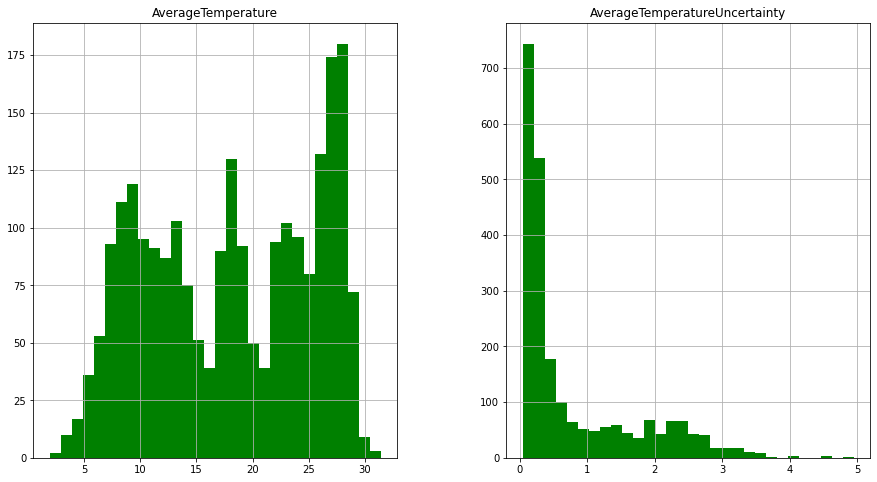

In [14]:
#initial plots
df.hist(bins=30,figsize=(15,8),color='green')

### Split data

In [15]:
# set train size to be 50% of total 
train_size = int(len(df) * .5)
train_size

1162

In [16]:
# set validate size to be 30% of total 
validate_size = int(len(df) * .3)
validate_size

697

In [17]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

466

In [18]:
# validate will go from 697 to 697+1162
validate_end_index = train_size + validate_size
validate_end_index

1859

In [19]:
# train will go from 0 to 1161
train = df[: train_size]
# validate will go from 1162 to 1858
validate = df[train_size:validate_end_index]
# test will include 1859 to the end
test = df[validate_end_index:]

In [20]:
#Verify Splits
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


In [21]:
print(df.head(1) == train.head(1))


            AverageTemperature  AverageTemperatureUncertainty
dt                                                           
1820-01-01                True                           True


In [22]:
#Let's plot our data first, viewing where the data is split into train and test.
train.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty'], dtype='object')

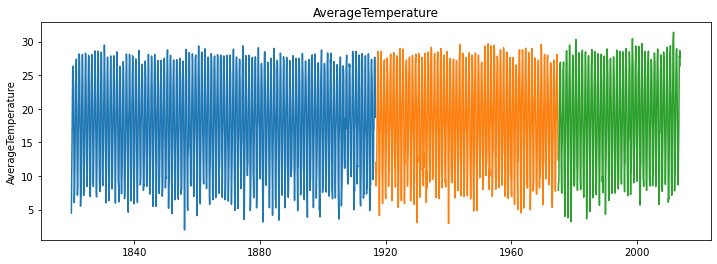

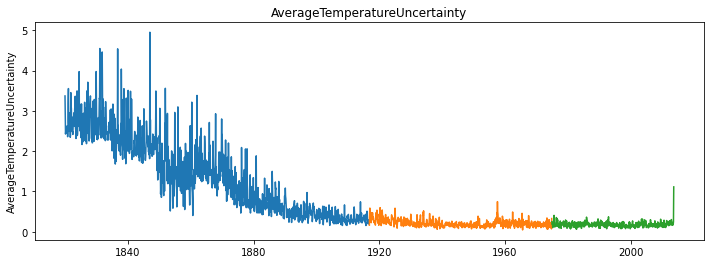

In [23]:
for col in train.columns:
    if col != 'State':
        plt.figure(figsize=(12,4))
        plt.plot(train[col])
        plt.plot(validate[col])
        plt.plot(test[col])
        plt.ylabel(col)
        plt.title(col)
        plt.show()

## Explore

In [24]:
#add month and year column
train['month'] = train.index.month
train['year'] = train.index.year

train.head()

,AverageTemperature,AverageTemperatureUncertainty,month,year
dt,,,,
1820-01-01,4.489,3.369,1,1820
1820-02-01,9.081,2.873,2,1820
1820-03-01,12.657,2.423,3,1820
1820-04-01,19.215,2.501,4,1820
1820-05-01,22.577,2.495,5,1820


In [25]:
#set target y variables
y = train.AverageTemperature
y_unc = train.AverageTemperatureUncertainty

y.head(), y_unc.head()

(dt
 1820-01-01     4.489
 1820-02-01     9.081
 1820-03-01    12.657
 1820-04-01    19.215
 1820-05-01    22.577
 Name: AverageTemperature, dtype: float64,
 dt
 1820-01-01    3.369
 1820-02-01    2.873
 1820-03-01    2.423
 1820-04-01    2.501
 1820-05-01    2.495
 Name: AverageTemperatureUncertainty, dtype: float64)

### Does the data increase, decrease, or stay the same over time?

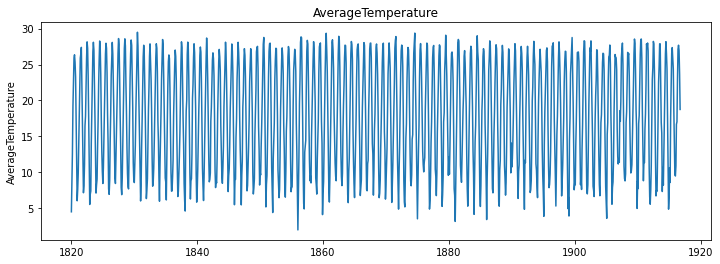

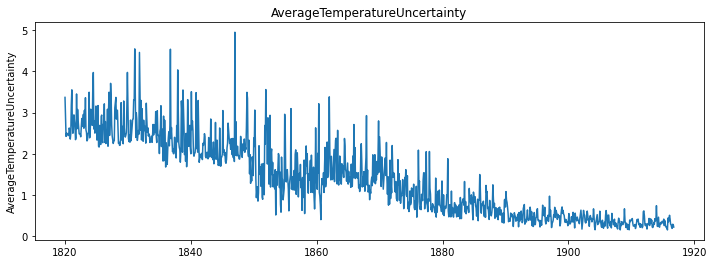

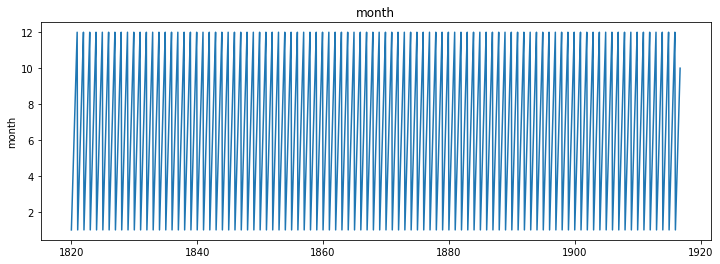

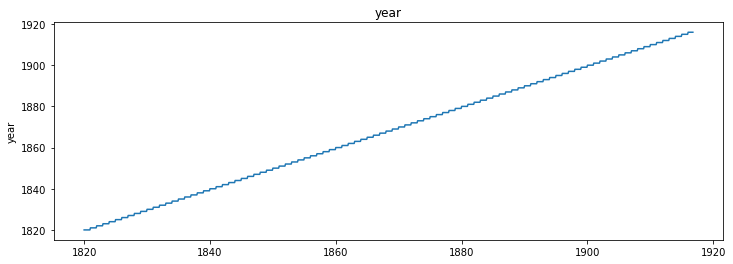

In [26]:
#loop to visualize avg temp/avg temp uncertainty over time
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### What is the distribution of yearly average temperature and yearly average uncertainty?

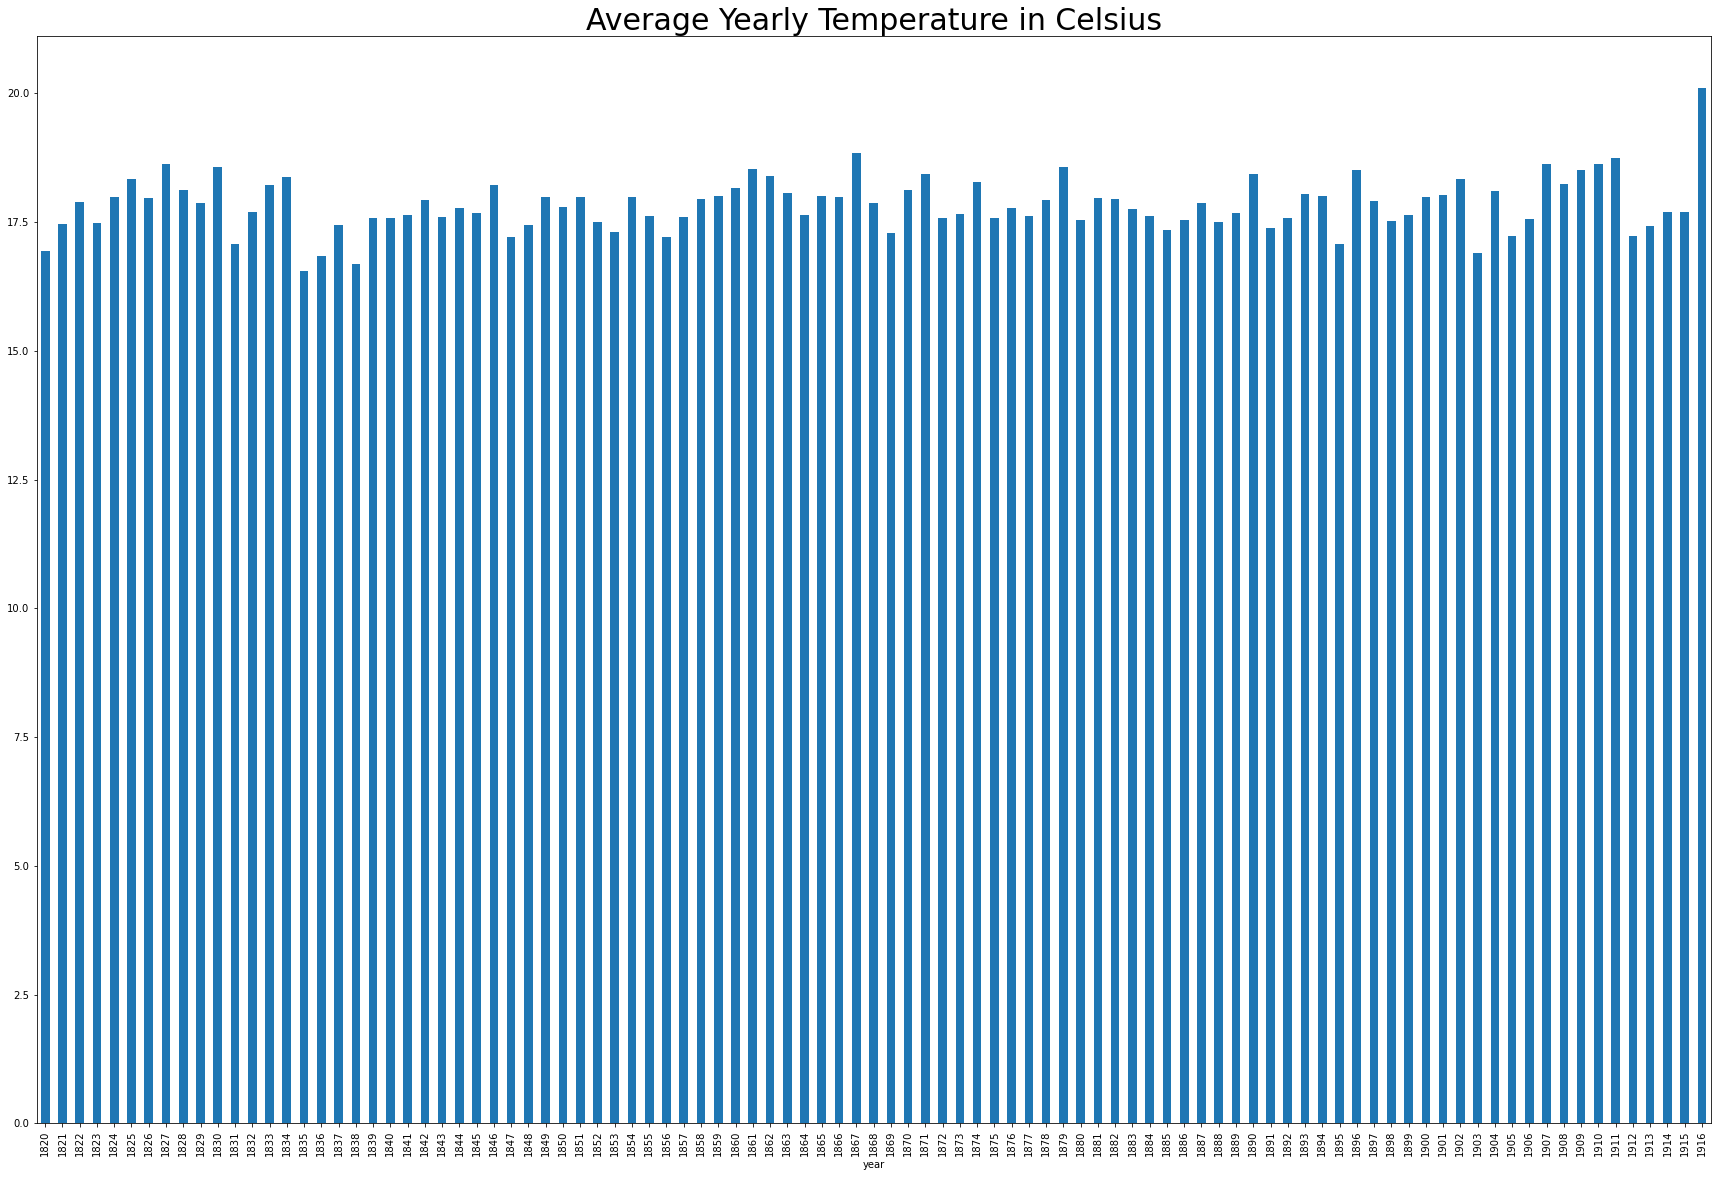

In [27]:
#yearly average temperature
train.groupby('year').AverageTemperature.mean().plot.bar(figsize=(30,20))
plt.title('Average Yearly Temperature in Celsius', fontsize=30)
plt.show()

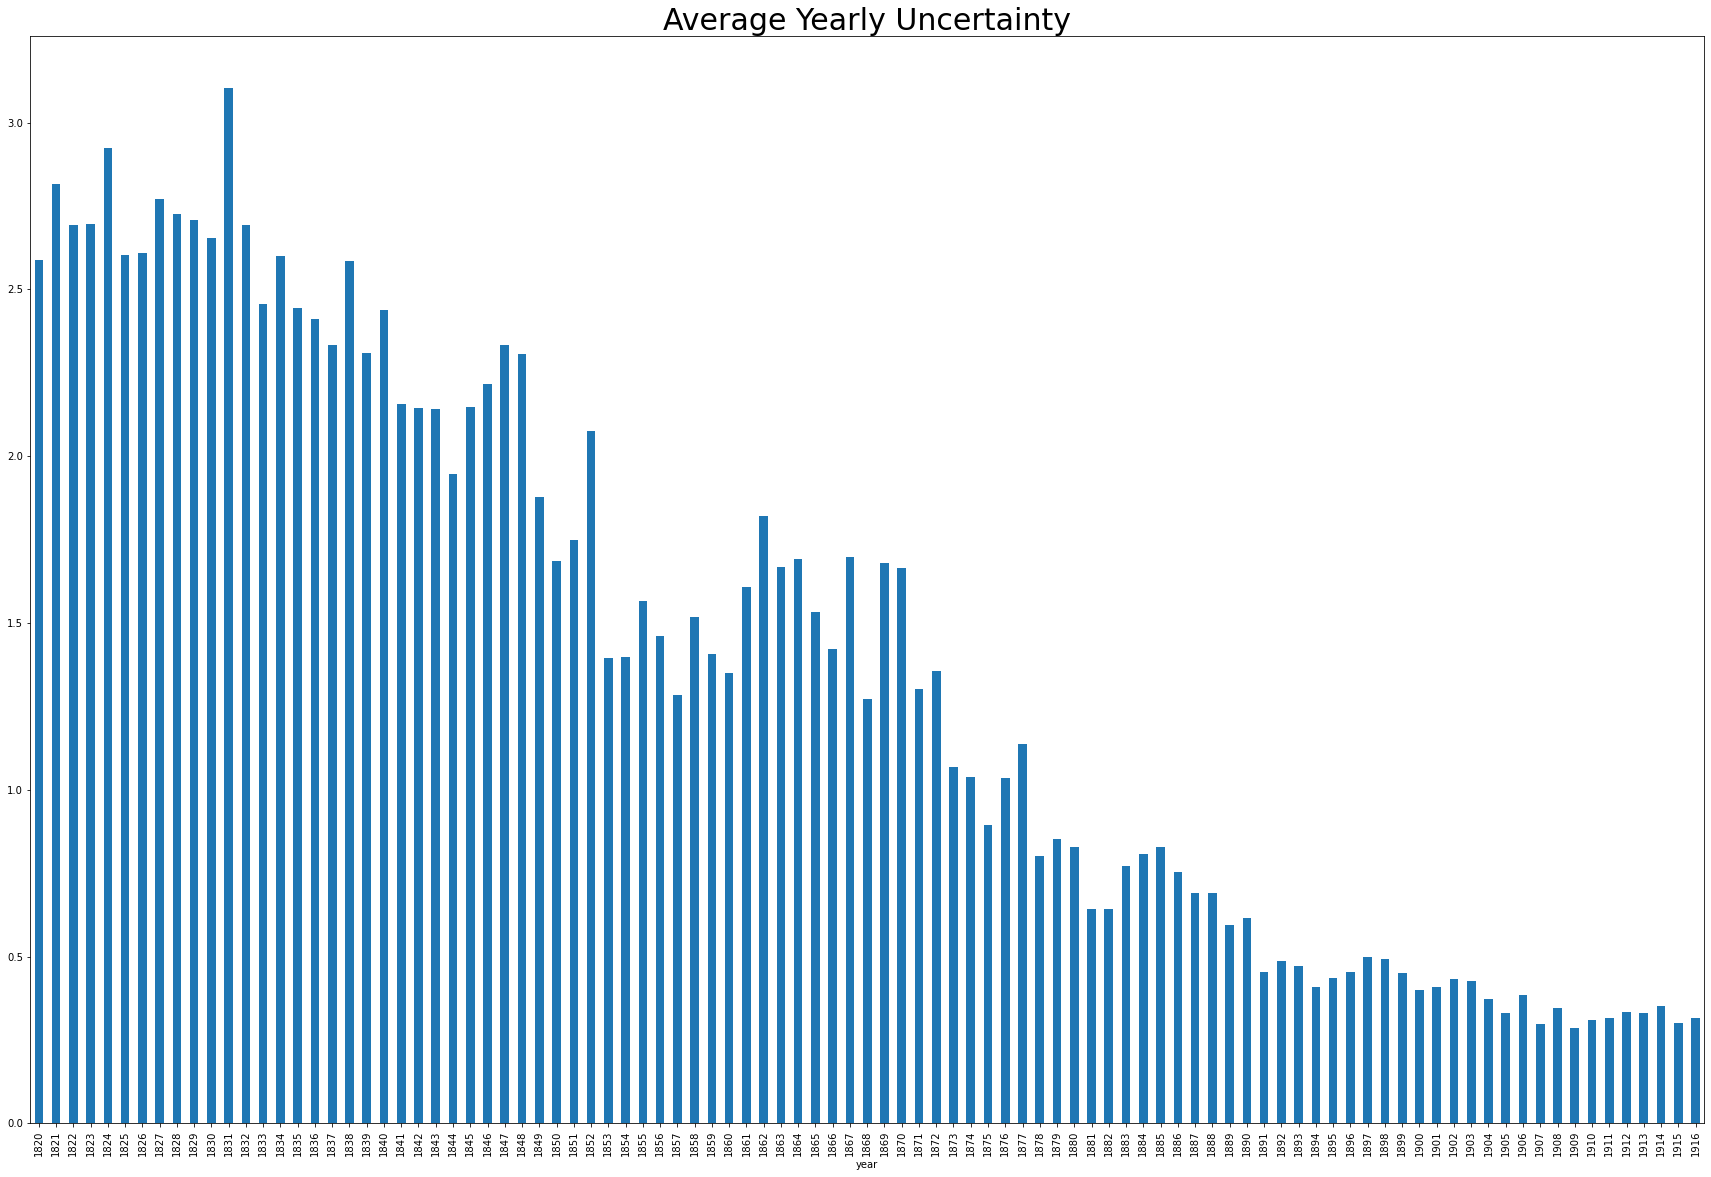

In [28]:
#yearly average uncertainty
train.groupby('year').AverageTemperatureUncertainty.mean().plot.bar(figsize=(30,20))
plt.title('Average Yearly Uncertainty', fontsize=30)
plt.show()

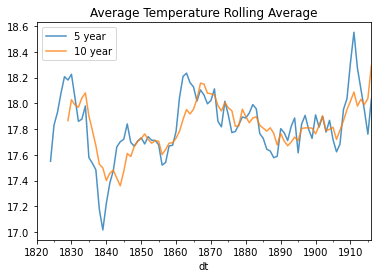

In [29]:
#reducing noise by resampling avg_temp data and rolling averages
y.resample('Y').mean().rolling(5).mean().plot(alpha=.8, label='5 year')
y.resample('Y').mean().rolling(10).mean().plot(alpha=.8, label='10 year')
plt.legend()
plt.title('Average Temperature Rolling Average')
plt.show()

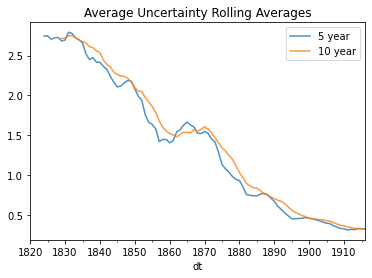

In [30]:
#reducing noise by resampling avg_uncertainty and rolling averages
y_unc.resample('Y').mean().rolling(5).mean().plot(alpha=.8, label='5 year')
y_unc.resample('Y').mean().rolling(10).mean().plot(alpha=.8, label='10 year')
plt.legend()
plt.title('Average Uncertainty Rolling Averages')
plt.show()

### What is the distribution of monthly average temperature and monthly average uncertainty?


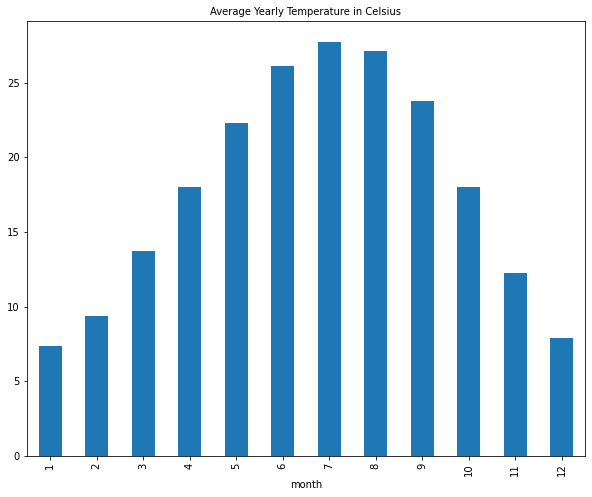

In [31]:
#monthly average temperature
train.groupby('month').AverageTemperature.mean().plot.bar(figsize=(10,8))
plt.title('Average Yearly Temperature in Celsius', fontsize=10)
plt.show()

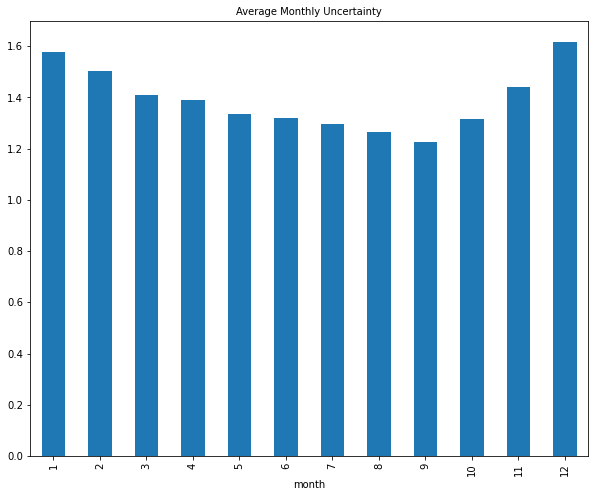

In [32]:
#monthly average uncertainty
train.groupby('month').AverageTemperatureUncertainty.mean().plot.bar(figsize=(10,8))
plt.title('Average Monthly Uncertainty', fontsize=10)
plt.show()

## Modeling/Evaluation

In [33]:
#dropping month and year columns for modeling/evaluation purposes
train = train.drop(columns=['month', 'year'])

train.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1820-01-01,4.489,3.369
1820-02-01,9.081,2.873
1820-03-01,12.657,2.423
1820-04-01,19.215,2.501
1820-05-01,22.577,2.495


In [34]:
def make_predictions():
    yhat_df = pd.DataFrame({'AverageTemperature': [AverageTemperature], 
                        'AverageTemperatureUncertainty': [AverageTemperatureUncertainty]}, 
                      index = validate.index)
    return yhat_df

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.2f}'.format(rmse))
    plt.show()
    
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Last Observed Value

In [38]:
#take the last value of avg temp and assign to variable
AverageTemperature = round(train['AverageTemperature'][-1:][0], 2)
AverageTemperature

18.74

In [39]:
#take the last value of avg_uncertainty and assign to variable
AverageTemperatureUncertainty = round(train['AverageTemperatureUncertainty'][-1:][0], 2)
AverageTemperatureUncertainty

0.22

In [40]:
#Create the yhat dataframe and fill with last observed values
yhat_df = pd.DataFrame({'AverageTemperature': [AverageTemperature], 
                        'AverageTemperatureUncertainty': [AverageTemperatureUncertainty]}, 
                      index = validate.index)

yhat_df.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1916-11-01,18.74,0.22
1916-12-01,18.74,0.22
1917-01-01,18.74,0.22
1917-02-01,18.74,0.22
1917-03-01,18.74,0.22


In [41]:
#yhat df
yhat_df = make_predictions()
yhat_df.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1916-11-01,18.74,0.22
1916-12-01,18.74,0.22
1917-01-01,18.74,0.22
1917-02-01,18.74,0.22
1917-03-01,18.74,0.22


In [42]:
#double check values are the same
yhat_df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,6.970000e+02,6.970000e+02
mean,1.874000e+01,2.200000e-01
std,1.813185e-13,9.721428e-16
min,1.874000e+01,2.200000e-01
25%,1.874000e+01,2.200000e-01
50%,1.874000e+01,2.200000e-01
75%,1.874000e+01,2.200000e-01
max,1.874000e+01,2.200000e-01


In [43]:
#double check values are the same
yhat_df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,6.970000e+02,6.970000e+02
mean,1.874000e+01,2.200000e-01
std,1.813185e-13,9.721428e-16
min,1.874000e+01,2.200000e-01
25%,1.874000e+01,2.200000e-01
50%,1.874000e+01,2.200000e-01
75%,1.874000e+01,2.200000e-01
max,1.874000e+01,2.200000e-01


AverageTemperature -- RMSE: 7.00


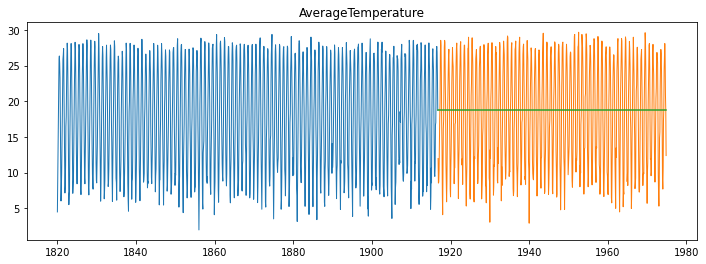

AverageTemperatureUncertainty -- RMSE: 0.00


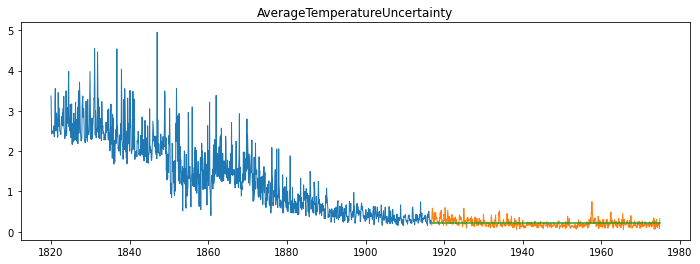

In [44]:
#plot actual vs predicted
for col in train.columns:
    plot_and_eval(col)

In [45]:
#evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.0
1,last_observed_value,AverageTemperatureUncertainty,0.0


## Moving Average

In [46]:
periods = [1, 5, 10, 20, 30]

for p in periods: 
    AverageTemperature = round(train['AverageTemperature'].rolling(p).mean()[-1], 2)
    AverageTemperatureUncertainty = round(train['AverageTemperatureUncertainty'].rolling(p).mean()[-1],2)
    yhat_df = make_predictions()
    model_type = str(p) + 'y_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [47]:
eval_df


,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.0
1,last_observed_value,AverageTemperatureUncertainty,0.0
2,1y_moving_avg,AverageTemperature,7.0
3,1y_moving_avg,AverageTemperatureUncertainty,0.0
4,5y_moving_avg,AverageTemperature,10.0
5,5y_moving_avg,AverageTemperatureUncertainty,0.0
6,10y_moving_avg,AverageTemperature,8.0
7,10y_moving_avg,AverageTemperatureUncertainty,0.0
8,20y_moving_avg,AverageTemperature,8.0
9,20y_moving_avg,AverageTemperatureUncertainty,0.0


AverageTemperature -- RMSE: 7.00


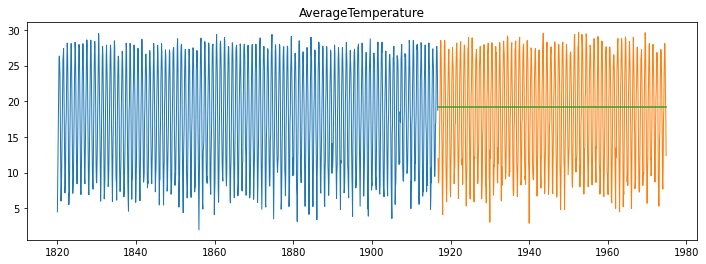

AverageTemperatureUncertainty -- RMSE: 0.00


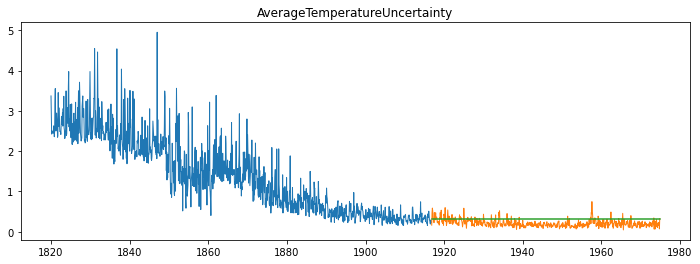

In [48]:
#plot actual vs predicted
for col in train.columns:
    plot_and_eval(col)

## Holt's Linear Trend

AverageTemperature 



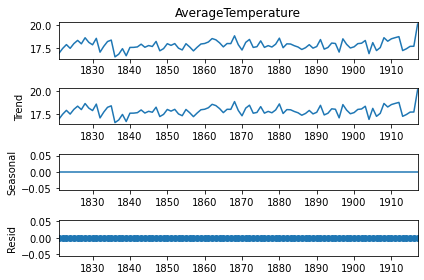

AverageTemperatureUncertainty 



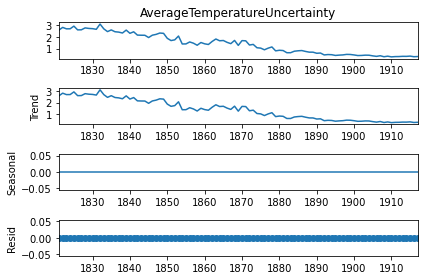

In [49]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('Y').mean()).plot()
    plt.show()

In [50]:
for col in train.columns:
    model = Holt(train[col], exponential=True, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)
    
yhat_df.head()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,AverageTemperature,AverageTemperatureUncertainty
dt,,
1916-11-01,16.08,0.3
1916-12-01,14.03,0.3
1917-01-01,12.58,0.3
1917-02-01,11.53,0.3
1917-03-01,10.75,0.3


AverageTemperature -- RMSE: 13.00


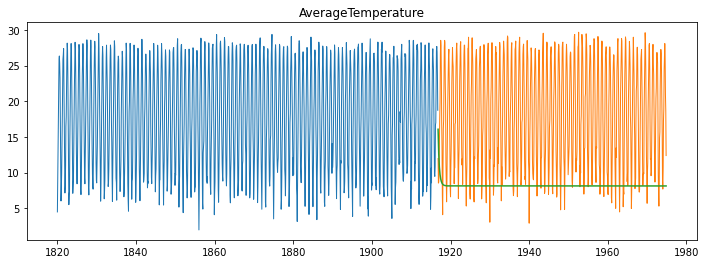

AverageTemperatureUncertainty -- RMSE: 0.00


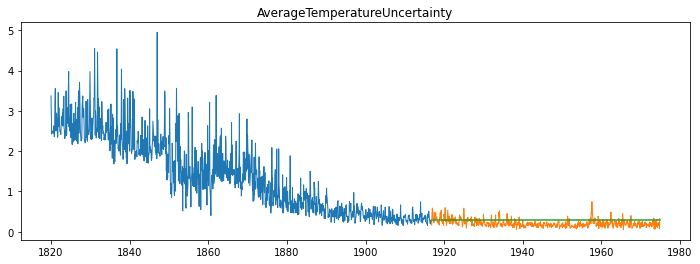

In [51]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [52]:
#append eval dataframe with holts optimized model evaluation metrics
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.0
1,last_observed_value,AverageTemperatureUncertainty,0.0
2,1y_moving_avg,AverageTemperature,7.0
3,1y_moving_avg,AverageTemperatureUncertainty,0.0
4,5y_moving_avg,AverageTemperature,10.0
5,5y_moving_avg,AverageTemperatureUncertainty,0.0
6,10y_moving_avg,AverageTemperature,8.0
7,10y_moving_avg,AverageTemperatureUncertainty,0.0
8,20y_moving_avg,AverageTemperature,8.0
9,20y_moving_avg,AverageTemperatureUncertainty,0.0


In [53]:
#changing hyperparameters
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=.1, 
                      smoothing_slope=.1, 
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


AverageTemperature -- RMSE: 102.00


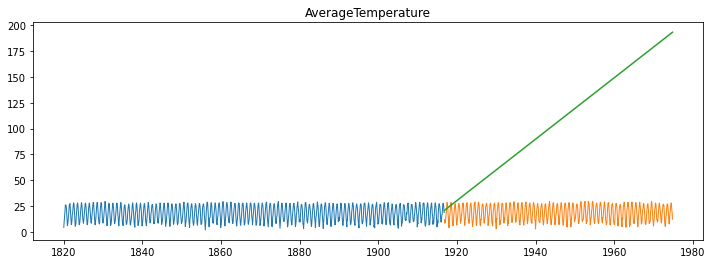

AverageTemperatureUncertainty -- RMSE: 1.00


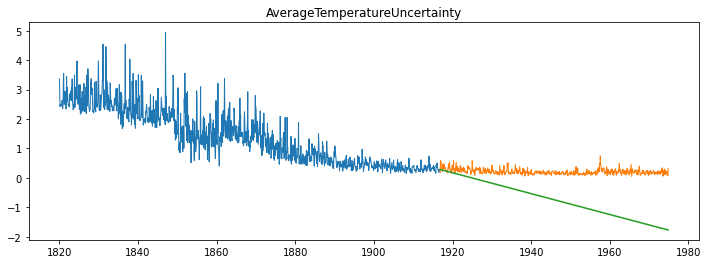

In [54]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [55]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
1,last_observed_value,AverageTemperatureUncertainty,0.0
3,1y_moving_avg,AverageTemperatureUncertainty,0.0
5,5y_moving_avg,AverageTemperatureUncertainty,0.0
7,10y_moving_avg,AverageTemperatureUncertainty,0.0
9,20y_moving_avg,AverageTemperatureUncertainty,0.0
11,30y_moving_avg,AverageTemperatureUncertainty,0.0
13,holts_optimized,AverageTemperatureUncertainty,0.0
15,holts_.1,AverageTemperatureUncertainty,1.0
0,last_observed_value,AverageTemperature,7.0
2,1y_moving_avg,AverageTemperature,7.0


## Previous Cycle 

Take all the previous year's data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give the forecast for that day.

In [56]:
#re-split data
train = df[:'2010']
validate = df['2011']
test = df['2012']

train.shape, validate.shape, test.shape

((2292, 2), (12, 2), (12, 2))

In [57]:
# finding the year-over-year difference for each day from 1820 to 2010
# taking the mean, and then adding that value to the daily 2010 values. 

yhat_df = train['2010'] + train.diff(365).mean()
yhat_df.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
2010-01-01,6.924656,-0.31578
2010-02-01,6.785656,-0.31178
2010-03-01,12.917656,-0.21478
2010-04-01,18.633656,-0.33178
2010-05-01,23.584656,-0.28178


In [58]:
#peeking into the prediction for 1/1/2011 by comparing predicted value (2010 value + y-o-y avg diff)to actual 1/1/2011 value
pd.concat([yhat_df.head(1), validate.head(1)])

,AverageTemperature,AverageTemperatureUncertainty
dt,,
2010-01-01,6.924656,-0.31578
2011-01-01,7.121000,0.19800


In [59]:
# set yhat_df to index of validate

yhat_df.index = validate.index
yhat_df

,AverageTemperature,AverageTemperatureUncertainty
dt,,
2011-01-01,6.924656,-0.31578
2011-02-01,6.785656,-0.31178
2011-03-01,12.917656,-0.21478
2011-04-01,18.633656,-0.33178
2011-05-01,23.584656,-0.28178
2011-06-01,28.538656,-0.27478
2011-07-01,27.885656,-0.21478
2011-08-01,29.569656,-0.15178
2011-09-01,25.788656,-0.29678


AverageTemperature -- RMSE: 2.00


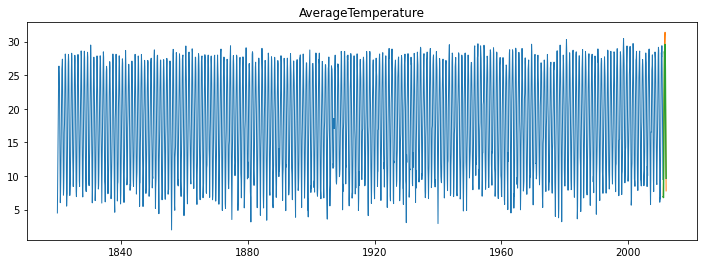

AverageTemperatureUncertainty -- RMSE: 0.00


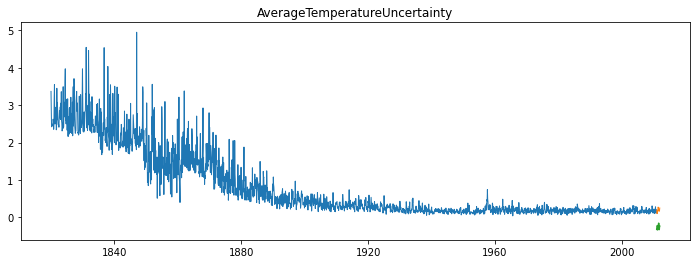

In [60]:
#plot and evaluate
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_cycle", 
                            target_var = col)

In [61]:
#find which model did that best
avg_temp_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

avg_uncertainty_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

eval_df[((eval_df.rmse == avg_temp_rmse) | 
         (eval_df.rmse == avg_uncertainty_min_rmse))]


avg_temp_min_rmse= eval_df.groupby('target_var')['rmse'].min()[0]

avg_uncertainty_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

eval_df[((eval_df.rmse == avg_temp_min_rmse) | 
         (eval_df.rmse == avg_uncertainty_min_rmse))]

,model_type,target_var,rmse
1,last_observed_value,AverageTemperatureUncertainty,0.0
3,1y_moving_avg,AverageTemperatureUncertainty,0.0
5,5y_moving_avg,AverageTemperatureUncertainty,0.0
7,10y_moving_avg,AverageTemperatureUncertainty,0.0
9,20y_moving_avg,AverageTemperatureUncertainty,0.0
11,30y_moving_avg,AverageTemperatureUncertainty,0.0
13,holts_optimized,AverageTemperatureUncertainty,0.0
16,previous_cycle,AverageTemperature,2.0
17,previous_cycle,AverageTemperatureUncertainty,0.0


### Previous cycle model performs the best for avg_temp and avg_uncertainty, so it will be used moving forward for out of sample data.

In [62]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [63]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.xlim(left = 1990)
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [65]:
rmse_avg_temp = sqrt(mean_squared_error(test['AverageTemperature'], 
                                       yhat_df['AverageTemperature']))

rmse_avg_uncertainty = sqrt(mean_squared_error(test['AverageTemperatureUncertainty'], 
                                       yhat_df['AverageTemperatureUncertainty']))

In [66]:
print('rmse_avg_temp: ', rmse_avg_temp)
print('rmse_avg_uncertainty: ', rmse_avg_uncertainty)

rmse_avg_temp:  1.678426389948172
rmse_avg_uncertainty:  0.4702299003760622


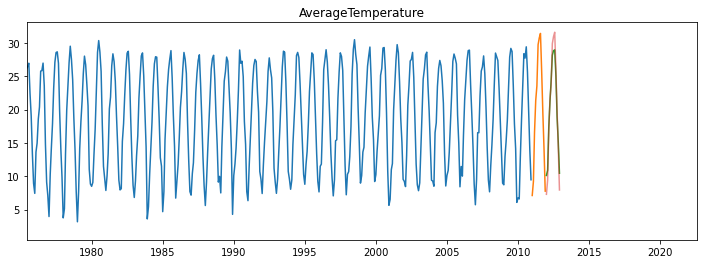

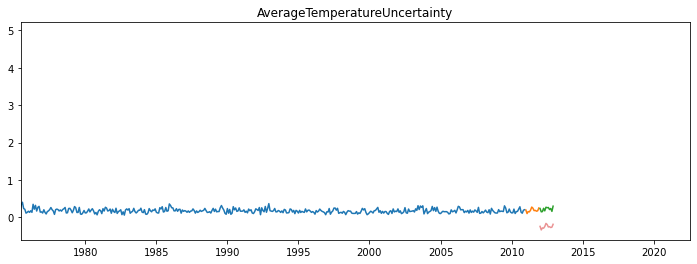

In [67]:
for col in train.columns:
    final_plot(col)

## Conclusion
Previous cycle model performs with an average temperature error of 1.68 degrees Celsius. This would be the best performing model moving forward for predicting average temperature and average temperature uncertainity for Texas.